Hi all!
In this script, we use (deep) reinforcement learning to solve the knapsack problem.

What is the knapsack problem (KP)? 
The KP is a problem where you are given a knapsack (a bag) with limited capacity and a set of objets.
Objects have two attributes, prize and weight. Your goal is to select some objects such that you maximize the prize of the object chosen without exceeding the capacity of the knapsack.

For example, given a knapsack of capacity 1 (also in the following, we assume weights to be normalized, so capacity knapsack = 1) and objects [prize, weight] = {[3,0.8],[1,0.25],[1,0.25],[1,0.25],[1,0.25]} the best solution would be to NOT pick up $obj_{0}$ (even if it has the greatest prize) while picking up all the other objects.

Why I've chosen the KP? Because the KP is often considered the easiet among the NP-Hard problem (meaning that it takes exponential number of steps to achieve the optimal solution)

The ingredients of out RL will be the following:
- multi task RL (because every instance is different)
- DQN: deep Q-network
- value approxiamtion via deep NN. Since the solution does not depends on the order of the objects (and for many other reasons), we use the attention mechanism in the NN. Attention is permutation - indifferent.
- off policy. We use eps-greedy to explore but we use greedy to test.

The overall script will be devided in (more or less) five big modules for repetibility usage.
1. environment (generate tasks, new states, rewards,..)
2. replay memory (memorizes transitions)
3. Model (decides the exploration/evaluation policy)
4. Learner (updates the model. input: memory, model)
5. Runner (runs episodes. input: environment, model)

a sixth module for printing is present, but that does not affect the overall algorithm.

As always, we start by importing useful libraries

In [1]:
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd
import random
import itertools
import copy
import time 
from collections import deque # for the buffer
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

%matplotlib inline

random.seed(1234)

import torch
if torch.cuda.is_available():
    print('GPU')

/home/big_bamboo/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# I still doesnt work I dont get why I cant enable notebook extensions
# make sure you have the pep8_magic installed
# jupyter nbextension install --user pep8_magic.py
#%load_ext pep8_magic
#%pep8
#a=1

Then we define the first big module: ENVIRONMENT
- the environment generates a task with num_objs (input) objects. 
- the enviroment can either generate a real instance (by default) or a fake one of which we know the optimal solution.
- the environment returns the objects and their heuristic solution value (which is computed via an heuristic). # CHANGE THIS

NOTE! for some aspects, what we call environment is actually more a task than an environment.

In [3]:
class ObjectCass:
    
    Prize = None
    Weight = None
    Ratio = None
    
    def __init__(self, reward, weight):
        
        # reward and weight are float tensors
        self.Prize = reward
        self.Weight = weight
        self.Ratio = reward/weight

def StateMaskFunction(state, Task):
        
    indexes = torch.Tensor([i for i in range(len(Task.Objects)) 
                if i not in state.Chosen and 
                not (state.res_capacity - Task.Objects[i].Weight < 0)]).long()

    return indexes 

class StateClass:
    
    ObjectsFeatures = None
    res_capacity = None
    Chosen = None
    price = None
    Final = None
    IndexesActionsNotMasked = None
    
    def __init__(self, ObjectsFeatures, res_capacity, Chosen, price, Task):
        
        self.res_capacity = res_capacity
        self.Chosen = Chosen
        self.price = price
        self.Final = 0
        self.IndexesActionsNotMasked = StateMaskFunction(self, Task)
        if len(self.IndexesActionsNotMasked)==0:
            self.Final=1
        self.ObjectsFeatures = ObjectsFeatures
        
        # change the boolean feature of the not selectable actions
        for i in range(len(self.ObjectsFeatures)):
            if i not in self.IndexesActionsNotMasked:
                self.ObjectsFeatures[i][-2]=0

        return
    
class TaskClass:
    
    Objects = None
    total_capacity = None
    heuristic = None
    
    def __init__(self, Objects, total_capacity, opt_solution = 'dummy'):
        
        self.Objects = Objects
        self.total_capacity = total_capacity
        self.heuristic = self.Heuristic(Objects)
        if opt_solution:
            self.opt_solution = opt_solution

    def Heuristic(self, Objects):
    
        Objects_sorted = sorted(Objects, key=lambda obj: -float(obj.Prize)/obj.Weight)
        weight_total = torch.tensor(0).float()
        price_total  = torch.tensor(0).float()
        for obj in Objects_sorted:
            if weight_total+obj.Weight>1:
                continue
            price_total+=obj.Prize
            weight_total+=obj.Weight

        return price_total
    
    def initial_state(self):
        
        price   = torch.tensor(0).float() #
        boolean = torch.tensor(1).float()
        
        ObjectsFeatures = []
        for i in range(len(self.Objects)):
            ObjectsFeatures.append(torch.stack([self.Objects[i].Prize, self.Objects[i].Weight, self.Objects[i].Ratio, boolean , self.total_capacity]))
        ObjectsFeatures = torch.stack(ObjectsFeatures) 
        
        return StateClass(ObjectsFeatures, self.total_capacity, torch.tensor([], dtype=torch.long), price, self)
    
    def step(self, state_old, action):
    
        # selecting object weight 
        # the trick is to first isolate the row related to the action
        # then to isolate the element number torch.tensor(1) which is the weight
        # the zero in fuction index_select are the dimensions,
        # which is basically how you read the tensor
        obj_features = state_old.ObjectsFeatures.index_select(0, action).squeeze()
        obj_weight = obj_features.index_select(0, torch.tensor(1)).squeeze()
        obj_price = obj_features.index_select(0, torch.tensor(0)).squeeze()
        capacity = state_old.res_capacity-obj_weight
        price = state_old.price+obj_price
        New_Chosen = state_old.Chosen.clone()
        action = action.long()
        New_Chosen = torch.cat((
            New_Chosen, 
            action.unsqueeze(dim=0)
                               ))
        ObjectsFeatures = state_old.ObjectsFeatures.clone()
        
        for i in range(len(ObjectsFeatures)):
            ObjectsFeatures[i][-1] = capacity
        # the boolens of the unchosable objects will be set to zero with the following command
        state_new = StateClass(ObjectsFeatures, capacity, New_Chosen, price, self)
        
        # new state , reward
        return state_new, self.Objects[action].Prize

class EnvironmentClass:
    
    num_objs = None
    
    def __init__(self, num_objs_min, num_objs_max):
        
        self.num_objs_min = num_objs_min
        self.num_objs_max = num_objs_max
        if self.num_objs_min > self.num_objs_max:
            print('wrong entries for environment class')
            error
        
        return
    
    def NewTask(self, FakeBool = False, prize_min=0.01, prize_max=1, weight_min=0.01, weight_max=1, shuffle = False):
          
        num_objs = random.choice(range(self.num_objs_min,self.num_objs_max+1))
        if FakeBool:
            # fake task
            # best solution = [1,0,1,0,1,0,1,0,1,0,1]
            Objects = []
            for i in range(num_objs):
                if i%2==1:
                    prize = 0.1
                    weight = 0.99
                    obj = ObjectCass(prize,weight)
                    Objects.append(obj)
                else:
                    prize = 1
                    weight = (2/float(num_objs))-0.001
                    obj = ObjectCass(prize,weight)
                    Objects.append(obj)
            if shuffle:
                random.shuffle(Objects)

        else:
            Objects = []
            for i in range(num_objs):
                prize  = torch.tensor(random.uniform(prize_min, prize_max))
                weight = torch.tensor(random.uniform(weight_min, weight_max))
                obj = ObjectCass(prize,weight)
                Objects.append(obj)

        capacity = torch.tensor(1).float() #

        self.Objects = Objects
        self.capacity = capacity
            
        return TaskClass(Objects, capacity)   
    
    def InitialStateNewTask(self, FakeBool = False, prize_min=1e-6, prize_max=1, weight_min=1e-6, weight_max=1, shuffle = False):
        
        Task = self.NewTask(FakeBool = False, prize_min=1e-6, prize_max=1, weight_min=1e-6, weight_max=1, shuffle = False)
        initial_state = Task.initial_state()
        
        return initial_state, Task
    
#just trying if it works
env = EnvironmentClass(2,5)
s_0, task = env.InitialStateNewTask()
s_1, reward = task.step(s_0,torch.tensor(0))
print('s_0 cap', s_0.res_capacity)
print('s_1 cap', s_1.res_capacity)
print('s_0 total reward', s_0.price)
print('s_1 total reward', s_1.price)
print('s_0 obj features', s_0.ObjectsFeatures)
print('s_1 obj features', s_1.ObjectsFeatures)
print('reward', reward)
s_2, reward = task.step(s_1,torch.tensor(1))
print(s_0.Chosen)
print(s_0.IndexesActionsNotMasked)
print(s_1.Chosen)
print(s_1.IndexesActionsNotMasked)
print(s_2.Chosen)
print(s_2.IndexesActionsNotMasked)

s_0 cap tensor(1.)
s_1 cap tensor(0.9094)
s_0 total reward tensor(0.)
s_1 total reward tensor(0.1169)
s_0 obj features tensor([[0.1169, 0.0906, 1.2891, 1.0000, 1.0000],
        [0.9425, 0.8070, 1.1679, 1.0000, 1.0000],
        [0.0349, 0.6931, 0.0504, 1.0000, 1.0000],
        [0.0984, 0.3546, 0.2775, 1.0000, 1.0000],
        [0.0174, 0.9867, 0.0177, 1.0000, 1.0000]])
s_1 obj features tensor([[0.1169, 0.0906, 1.2891, 0.0000, 0.9094],
        [0.9425, 0.8070, 1.1679, 1.0000, 0.9094],
        [0.0349, 0.6931, 0.0504, 1.0000, 0.9094],
        [0.0984, 0.3546, 0.2775, 1.0000, 0.9094],
        [0.0174, 0.9867, 0.0177, 0.0000, 0.9094]])
reward tensor(0.1169)
tensor([], dtype=torch.int64)
tensor([0, 1, 2, 3, 4])
tensor([0])
tensor([1, 2, 3])
tensor([0, 1])
tensor([], dtype=torch.int64)


Second big module: Model
- the model contains the training/evaluation policy and it is responsable for choosing the actions
- it contains the NN used for value function approximation

In [4]:
class Net_Attention(torch.nn.Module):
    
    def __init__(self, num_input_features,h_model, num_head ,num_layers, dim_feedforward, p_dropout, ):    
        
        super(Net_Attention, self).__init__()
        
        # from object features to high-dimension object features
        self.emb = torch.nn.Linear(num_input_features,  h_model)
        # transformer (encoder)
        encoder_layer = torch.nn.TransformerEncoderLayer(d_model=h_model, nhead=num_head, 
                                                   dim_feedforward=dim_feedforward, dropout=p_dropout)
        self.transformer_encoder = torch.nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers, norm = torch.nn.LayerNorm(h_model)
            )
        #        
        # FINAL LAYER
        self.final_layer_0 = torch.nn.Linear(h_model,h_model)
        self.final_layer_1 = torch.nn.Linear(h_model,1)

    def forward(self, States, no_grad = False):
        
        ObjectsFeatures = torch.stack([state.ObjectsFeatures for state in States])
        
        # define relu operation
        ReLU = torch.nn.ReLU()
        
        if no_grad: #doesn't compute the gradients (hence no back propagation, but faster). 
            with torch.no_grad(): # to be used only in evaluations and target (not in training the prediction)        
                E = self.emb(torch.transpose(ObjectsFeatures,0,1))                
                c = self.transformer_encoder(E)
                c = self.final_layer_0(c)
                c = ReLU(c)
                Qvals = self.final_layer_1(c)
                Qvals = torch.squeeze(Qvals, dim = 2)
                Qvals = torch.transpose(Qvals,0,1)
                
                return Qvals
            
        E = self.emb(torch.transpose(ObjectsFeatures,0,1))
        # where 
        # S is the source sequence length,  
        # N is the batch size,  
        # E is the feature number        
        # you want 
        # E.size() = S,N,E = num_obj x batch x h_model
        c = self.transformer_encoder(E)
        c = self.final_layer_0(c)
        c = ReLU(c)
        Qvals = self.final_layer_1(c)
        Qvals = torch.squeeze(Qvals, dim = 2)
        Qvals = torch.transpose(Qvals,0,1)
                
        return Qvals

class ModelClass():

    def __init__(self, Net_current, Net_target, training_policy, evaluation_policy, epsilon_max, epsilon_min):
        
        self.Net_current = Net_current
        self.Net_target  = Net_target
        if training_policy!='eps-greedy' or evaluation_policy!='greedy':
            print('at least one of this exploration/evaluation policy are still to implement')
            error
        else:
            self.epsilon_min = epsilon_min
            self.epsilon_max = epsilon_max
        self.training_policy   = training_policy
        self.evaluation_policy = evaluation_policy

    def Greedy(self, Qvals, state):
        
        Qvals_selectable = [Qvals[i] for i in range(len(Qvals)) if i in state.IndexesActionsNotMasked]
        Qvals_selectable = torch.stack(Qvals_selectable)
        action = torch.argmax(Qvals_selectable)
        action_index = state.IndexesActionsNotMasked[action]
        
        return action_index
    
    def EpsGreedy(self, Qvals,state, iteration_counter, num_iterations):
    
        # select action
        epsilon = (epsilon_max-epsilon_min)*(num_iterations-iteration_counter)/num_iterations + epsilon_min
        if random.random() < epsilon:
            action_index = random.choice(state.IndexesActionsNotMasked)
        else:
            action_index = self.Greedy(Qvals,state)
 
        return action_index
    
    def training_step(self, state, iteration_counter, num_iterations):

        self.Net_current.train()
        if self.training_policy == 'eps-greedy':
            Qvals = self.Net_current([state])
            Qvals = Qvals.squeeze()
            return self.EpsGreedy(Qvals, state, iteration_counter, num_iterations), Qvals
        error
    
    def evaluation_step(self, state):
        
        self.Net_current.eval()
        if self.evaluation_policy == 'greedy':
            Qvals = self.Net_current([state], no_grad = True)
            Qvals = Qvals.squeeze()
            return self.Greedy(Qvals, state)
        error

Now we have a function that, given a state, it returns the Q values. We have to define the loss 

Third module: BUFFER (aka replay memory)
- the buffer contains the last #replay_lenght transictions.
- each experience in the buffer is as a tuple <$s_{old}$, action, r, $s_{new}$>

In [5]:
class ReplayMemoryClass:
    
    replay_lenght = None
    minibatch_size = None
    Buffer = None
    new_transitions = None
    
    def __init__(self,replay_lenght, minibatch_size):
        
        self.replay_lenght = replay_lenght
        self.minibatch_size = minibatch_size
        self.Buffer = []
        self.new_transitions = 0
        
    def Add(self, Transitions):
                
        while len(self.Buffer)+len(Transitions)>=self.replay_lenght:
            self.Buffer.remove(self.Buffer[0])
        for t in Transitions:
            self.Buffer.append(t)
        self.new_transitions+=len(Transitions)
        
        return
        
    def Minibatch(self):
        
        if len(self.Buffer) <= self.minibatch_size:
            Minibatch = self.Buffer
            self.new_transitions = max(0, self.new_transitions-len(self.Buffer))
        else:
            if self.new_transitions == 0: # no priority
                Minibatch = random.sample(self.Buffer, self.minibatch_size)
            else:
                new_transitions = min(self.new_transitions, self.minibatch_size)
                Minibatch_new_transitions = [self.Buffer[i] 
                                             for i in range((len(self.Buffer)-new_transitions)
                                                            ,(len(self.Buffer)))]
                remaining_transitions = min(0, self.minibatch_size - new_transitions)
                Minibatch_random = random.sample(self.Buffer, remaining_transitions)
                Minibatch = Minibatch_new_transitions + Minibatch_random
                self.new_transitions-=new_transitions
                
        # the idea here is to order the minibatch with first the experieces with final = 0
        # and then the experiecnes with final = 1. This allows us in the learning_step
        # to work on the two cases separately and then just concatenate the results
        
        Minibatch.sort(key=lambda experience: experience[-1].Final)
        
        # CHANGE THE WAY YOU SAVE THINFS IN THE BUFFER!!!!
        # SAVE DIRECTLY AS THE LISTS BELOW
                
        States = [experience[0] for experience in Minibatch]
        Actions = torch.stack([experience[1] for experience in Minibatch]).unsqueeze(dim=1)
        Rewards = torch.stack([experience[2] for experience in Minibatch])
        New_States = [experience[3] for experience in Minibatch]
        
        Minibatch = [States, Actions, Rewards, New_States]
        
        return Minibatch

def Minibatch(ReplayMemoryList):
    
    " from a list of ReplayMemoryClass keep selecting one at random "
    " until you find one that is not empty. Then, return a minibatch from it "
    
    while True:
        # select at random one of the replay buffers
        replay_memory = random.choice(ReplayMemoryList)
        # if the selected replay buffer is empty, take a minibatch from it
        if len(replay_memory.Buffer)>0: 
            return replay_memory.Minibatch()

Fourth module: LEARNER
- receives minibatches
- updates the Model

In [6]:
class LearnerClass():

    Model = None
    optimizer = None
    gamma = None
    tau = None
    loss_method = None
    
    def __init__(self,Model, optimizer, tau, gamma = 1,loss_method = torch.nn.MSELoss(reduction='mean')):
        
        self.Model = Model
        self.optimizer = optimizer
        self.tau = tau
        self.gamma = gamma
        self.loss_method = loss_method

    def Learning_step(self, Minibatch):
                
        time_start = time.time()
        # zero the gradient buffers
        self.optimizer.zero_grad() 
        
        # 'get' data from the minibatch
        States, Actions, Rewards, New_States = Minibatch
        time_zero_grad = time.time() - time_start
        
        #
        # computing Q_vals of the new state (we split for final and nonfinal states)
        #
        time_start = time.time()
        New_States_nonFinal = [New_States[i] for i in range(len(New_States)) if New_States[i].Final==0]
        if len(New_States_nonFinal)>0:
            _, indexes = torch.max(self.Model.Net_target(New_States_nonFinal, no_grad = True), dim = 1)
            Max_New_States_nonFinal = self.Model.Net_current(New_States_nonFinal).gather(1, indexes.unsqueeze(dim = 1)).squeeze(dim = 1)
        else:
            Max_New_States_nonFinal = torch.tensor([])
                
        # here we take advantage of the fact that we ordered the minibatch with first all the nonfinal states
        # and then the final states. So we define a zero vector for the final states and we concatenate it to
        # the tensor of the Q_vals of the next state (for non final states)
        
        length_final_states = len(New_States)-len(New_States_nonFinal)
        if length_final_states>0:
            zeros = torch.zeros(length_final_states, dtype = torch.float)
            Max_New_States = torch.cat((Max_New_States_nonFinal, zeros))
        else: # all states are non final
            Max_New_States = Max_New_States_nonFinal
        
        # get Qvals for the 'old' states
        Predictions_Actions = self.Model.Net_current(States).gather(1, Actions).squeeze(dim = 1)
        
        # compute loss
        loss = self.loss_method(Predictions_Actions,Rewards + self.gamma*Max_New_States)
        time_compute_loss = time.time() - time_start
        
        time_start = time.time()
        # backpropagate loss
        loss.backward()
        time_backwards = time.time() - time_start

        time_start = time.time()
        # gradient clipping
        clip_value = 0.1
        grad_norm = torch.nn.utils.clip_grad_norm_(self.Model.Net_current.parameters(), clip_value)
        time_clipping = time.time() - time_start

        time_start = time.time()
        # apply gradient
        self.optimizer.step()
        time_step = time.time() - time_start

        time_start = time.time()
        # soft target update
        for param_target, param_current in zip(self.Model.Net_target.parameters(), self.Model.Net_current.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param_current.data * self.tau)        
        time_soft_update = time.time() - time_start

        Times = [
                 time_zero_grad, 
                 time_compute_loss, 
                 time_backwards,
                 time_clipping, 
                 time_step, 
                 time_soft_update
                ]
        
        return loss.tolist(), Times

Fifth module: RUNNER
- takes the environment and the module
- runs a transaction. Or should it run an episode?

In [7]:
class RunnerClass():

    Environment = None
    Model = None
    
    def __init__(self, Environment, Model):
        
        self.Model = Model
        self.Environment = Environment
        
    def NewTrainingTask(self, iteration_counter,num_iterations, task = 'dummy'):
        
        Transitions = []
        if task == 'dummy':
            state, task = self.Environment.InitialStateNewTask()
        else:
            state = task.initial_state()
        G = 0 # reward obtained
        while state.Final == 0:
            action_index, Q_vals = self.Model.training_step(state, iteration_counter,num_iterations)
            # save initial_Q_vals (for printing reasons)
            if G == 0: # it means this is the first action
                initial_Q_vals = Q_vals
            new_state, reward = task.step(state, action_index)
            G+=reward
            Transitions.append([state, action_index, reward, new_state])
            state = new_state
         
        return Transitions, task.heuristic, G, initial_Q_vals
    
    def NewEvaluationTask(self, task = 'dummy'):
        
        if task == 'dummy':
            state, task = self.Environment.InitialStateNewTask()
        else:
            state = task.initial_state()
        G = 0
        while state.Final == 0:
            action_index = self.Model.evaluation_step(state)
            new_state, reward = task.step(state, action_index)
            G+=reward
            state = new_state
         
        return G, task.heuristic

Now we create a function to evaluate the trained network

In [8]:
def Evaluate(num_iterations, Runner):
    
    better = 0
    G_tot = []
    heuristic_tot = []
    for iteration_counter in range(num_iterations):
        # perform new task
        G, heuristic = Runner.NewEvaluationTask()
        G_tot.append(G)
        heuristic_tot.append(heuristic)
        if G >= heuristic:
            better+=1
    print('the NN was better than (or equal to) the heuristic '+str(better)+' times out of '+str(num_iterations)) 
    
    R_norm = [G_tot[i]/heuristic_tot[i] for i in range(len(G_tot))]
    mean = np.mean(R_norm)
    std = np.std(R_norm)
    
    return mean, std

and we also define a function to print stuff.
(this function is not really smart, it recomputes the Q values. think of another way to do it)

In [9]:
class StuffToBePrintedClass():
    
    Initial_Qvals = None
    Gs = None
    heuristic_targets = None
    PATH = None
    Evaluation = None
    loss = None

    def __init__(self, path, Initial_Qvals, Gs, heuristic_targets, Evaluation, loss):
        
        self.PATH = path
        self.Initial_Qvals = Initial_Qvals
        self.Gs = Gs
        self.heuristic_targets = heuristic_targets
        self.Evaluation = Evaluation
        self.loss = loss
    
    def AddElements(self,Initial_Qvals='dummy', G='dummy', heuristic_target='dummy'
                   , Evaluation='dummy', loss='dummy'):
        
        """ comment what it does.
        """
        
        if Initial_Qvals!='dummy':
            self.Initial_Qvals.append(Initial_Qvals)
        if G!='dummy':
            self.Gs.append(G)
        if heuristic_target!='dummy':
            self.heuristic_targets.append(heuristic_target)
        if Evaluation!='dummy':
            self.Evaluation.append(Evaluation)
        if loss!='dummy':
            self.loss.append(loss)
            
        if G!='dummy' and Evaluation!='dummy':
            error
        
        return
    
    def Print(self):
        
        # Q vals
        self.PrintSequence(self.Initial_Qvals, 'Initial Qvals', Q_valsBool = True)
        Q_Actions_norm = []
        for i in range(len(self.Initial_Qvals)):
            Q_Action_i = [self.Initial_Qvals[i][j]/self.heuristic_targets[i] for j in range(len(self.Initial_Qvals[i]))]
            Q_Actions_norm.append(Q_Action_i)
        self.PrintSequence(Q_Actions_norm, 'Initial Qvals Normalized', Q_valsBool = True, Ones = True)
        # non Q vals
        self.PrintSequence(self.Gs, 'total rewards', y_min = 0, loc = 'lower right')
        Gs_norm = [self.Gs[i]/self.heuristic_targets[i] for i in range(len(self.Gs))]
        self.PrintSequence(Gs_norm, 'normalized total rewards', Ones = True, y_min = 0,loc = 'lower right')
        self.PrintSequence(self.loss, 'loss', y_min = 0, loc = 'upper right')
        # Evaluation
        self.PrintEvaluation()
        try:
            self.PrintSequence(self.training, 'training times')
        except:
            None
        try:
            self.PrintSequence(self.replay_buffer, 'replay buffer times')
        except:
            None
        try:
            self.PrintSequence(self.saving, 'saving data times')
        except:
            None
        try:
            Stringa = [
                 'time_zero_grad', 
                 'time_compute_loss', 
                 'time_backwards',
                 'time_clipping', 
                 'time_step', 
                 'time_soft_update'
            ]
            for i in range(len(self.learn[0])):
                seq = [self.learn[j][i] for j in range(len(self.learn))]
                self.PrintSequence(seq, 'learn times '+Stringa[i])
        except:
            None
        
        return
    
    def PrintSequence(self, sequence, string, Q_valsBool = False, Ones = False, y_min = False, loc = 'dummy'):
        
        plt.figure()
        x_axis = [i for i in range(len(sequence))]
        if not Q_valsBool:
            if len(sequence)>100:
                means, stds, x_axis = self.MeanAndStandard(sequence) 
                #plt.errorbar(x_axis, means, yerr=stds, label=string) #, fmt='o' if you want the ball
                y_low = [means[i]-stds[i] for i in range(len(means))]
                y_upp = [means[i]+stds[i] for i in range(len(means))]
                plt.fill_between(x_axis, y_low, y_upp, alpha=0.75,label=string)
                plt.plot(x_axis, means)
            else:
                plt.plot(sequence, label=string)
        else:
            if len(sequence)>100:
                for i in range(len(sequence[0])):
                    Q_Action_i = [sequence[j][i] for j in range(len(sequence))]
                    means, stds, x_axis = self.MeanAndStandard(Q_Action_i)
                    y_low = [means[i]-stds[i] for i in range(len(means))]
                    y_upp = [means[i]+stds[i] for i in range(len(means))]
                    plt.fill_between(x_axis, y_low, y_upp, alpha=0.2,label=string+'_act_'+str(i))
                    #plt.errorbar(x_axis, means, yerr=stds, label=string+'_act_'+str(i)) # fmt='o'
                    plt.plot(x_axis, means)
                Q_max = [max(Q_vals) for Q_vals in sequence]
                means, stds, x_axis = self.MeanAndStandard(Q_max)                
                y_low = [means[i]-stds[i] for i in range(len(means))]
                y_upp = [means[i]+stds[i] for i in range(len(means))]
                #plt.plot(x_axis, means, label='Q_Max')
                #plt.errorbar(x_axis, means, yerr=stds, label='Q_Max') #, fmt='o'
                plt.fill_between(x_axis, y_low, y_upp, alpha=0.2,label='Q_Max')
                plt.plot(x_axis, means)
            else:
                for i in range(len(sequence[0])):
                    Q_Action_i = [sequence[j][i] for j in range(len(sequence))]
                    plt.plot(Q_Action_i, label=string+'_act_'+str(i))
                Q_max = [max(Q_vals) for Q_vals in sequence]
                plt.plot(Q_max, label='Q_Max')
        if Ones:
            Ones = [1 for j in range(len(x_axis))]
            plt.plot(x_axis, Ones, label='normalized heuristic value')
        if y_min:
            plt.ylim(ymin=y_min)
        plt.legend()
        if loc!='dummy':
            leg = plt.legend(loc=loc)
        plt.savefig(self.PATH+string+'.png', bbox_inches='tight')
        
        # print a figure with just the maximum Q val (without the other Q vals)
        if Q_valsBool:
            plt.figure()
            Q_max = [max(Q_vals) for Q_vals in sequence]
            if len(sequence)>100:
                means, stds, x_axis = self.MeanAndStandard(Q_max)                
                y_low = [means[i]-stds[i] for i in range(len(means))]
                y_upp = [means[i]+stds[i] for i in range(len(means))]    
                plt.fill_between(x_axis, y_low, y_upp, alpha=0.75,label='Q_Max')
                plt.plot(x_axis, means)
            else:
                plt.plot(Q_max,label='Q_Max')
                x_axis = Q_max
            if Ones:
                Ones = [1 for j in range(len(x_axis))]
                plt.plot(x_axis, Ones, label='normalized heuristic value')
            plt.legend()
            leg = plt.legend(loc='upper left')
            plt.savefig(self.PATH+'Q_Max.png', bbox_inches='tight')
            
        return
    
    def MeanAndStandard(self, sequence):                
        
        unit = int(len(sequence)/100)
        Means = []
        STD = []
        Aux = []
        for i in range(len(sequence)):
            Aux.append(sequence[i])
            if i%unit==0 and i!=0:
                vector = np.array(Aux, dtype=float)
                mean = np.mean(vector)
                std = np.std(vector)
                Means.append(mean)
                STD.append(std)
                Aux = []
        x_axis = [i*unit for i in range(len(Means))]
        
        return Means, STD, x_axis

    def PrintEvaluation(self):

        plt.figure()
        means  = [single_evaluation[0] for single_evaluation in self.Evaluation]
        stds   = [single_evaluation[1] for single_evaluation in self.Evaluation]
        x_axis = [single_evaluation[2] for single_evaluation in self.Evaluation]

        plt.errorbar(x_axis, means, yerr=stds,fmt='o-', label = 'normalized rewards during evaluation') # 
        plt.ylim(bottom=0)
        Ones = [1 for j in range(len(x_axis))]
        plt.plot(x_axis, Ones, label = 'normalized heuristic rewards')
        plt.legend()
        leg = plt.legend( loc = 'lower right')
        
        plt.savefig(self.PATH+'Evaluation_Normalized_Rewards_per_iteration.png', bbox_inches='tight')
    
    def AddTime(self, time, stringa):
        
        if stringa == 'training':
            try:
                self.training.append(time)
            except:
                self.training = []
                self.training.append(time)
        if stringa == 'replay buffer':
            try:
                self.replay_buffer.append(time)
            except:
                self.replay_buffer = []
                self.replay_buffer.append(time)
        if stringa == 'learn':
            try:
                self.learn.append(time)
            except:
                self.learn = []
                self.learn.append(time)
        if stringa == 'saving data':
            try:
                self.saving.append(time)
            except:
                self.saving = []
                self.saving.append(time)
                
        return

def MaxInitialQvalues(Transitions, Net_predict):
    
    first_state, action_index, reward, new_state = Transitions[0]
    Qvals = Net_predict([first_state], no_grad = True)
    Qvals = Qvals.squeeze().tolist()
    
    return Qvals

The next cell contains functions to save and load the data.
The idea is to save data during training in PATH_AUX
and save data after training in PATH_Final

In [10]:
def SaveData(iteration_counter,Learner,Runner,ReplayMemory,StuffToBePrinted, PATH_save):
    
    with open(PATH_save+'RLKP-num_iterations_start-Save.pkl', 'wb') as output:
        pickle.dump(iteration_counter, output, pickle.HIGHEST_PROTOCOL)
    with open(PATH_save+'RLKP-Learner-Save.pkl', 'wb') as output:
        pickle.dump(Learner, output, pickle.HIGHEST_PROTOCOL)
    with open(PATH_save+'RLKP-Runner-Save.pkl', 'wb') as output:
        pickle.dump(Runner, output, pickle.HIGHEST_PROTOCOL)
    with open(PATH_save+'RLKP-ReplayMemory-Save.pkl', 'wb') as output:
        pickle.dump(ReplayMemory, output, pickle.HIGHEST_PROTOCOL)
    with open(PATH_save+'RLKP-StuffToBePrinted-Save.pkl', 'wb') as output:
        pickle.dump(StuffToBePrinted, output, pickle.HIGHEST_PROTOCOL)
    
    return

def LoadDataToTrain(Path_load):
    
    with open(Path_load+'RLKP-num_iterations_start-Save.pkl', 'rb') as input:
        num_iterations_start = pickle.load(input)
    with open(Path_load+'RLKP-Learner-Save.pkl', 'rb') as input:
        Learner = pickle.load(input)
    with open(Path_load+'RLKP-Runner-Save.pkl', 'rb') as input:
        Runner = pickle.load(input)
    env = Runner.Environment
    Model = Learner.Model
    Runner.Model = Model
    with open(Path_load+'RLKP-ReplayMemory-Save.pkl', 'rb') as input:
        ReplayMemory = pickle.load(input)
    with open(Path_load+'RLKP-StuffToBePrinted-Save.pkl', 'rb') as input:
        StuffToBePrinted = pickle.load(input)
        
    return num_iterations_start, Learner, Runner, env, Model, ReplayMemory, StuffToBePrinted

def LoadDataToEvaluate(Path_load):
    
    with open(Path_load+'RLKP-Runner-Save.pkl', 'rb') as input:
        Runner = pickle.load(input)
        
    return Runner

Now we create our 5 modules (or load them from existing ones)

In [11]:
# seed
random.seed(1234)
# num episode to be generated
num_iterations = int(1e4)
# num object per episode
num_objs_min = 5
num_objs_max = 100
num_input_features = 5 # prize, weight, ratio, res_capacity, Bool_alreday_chosen
# transformer details
h_model = 512
num_head = 8
num_layers = 6
dim_feedforward = h_model
p_dropout = 0.1
# learning rate
lr = 1e-4
# minimum and maximum epsilon value
epsilon_max = 1
epsilon_min = 0.05
# how many transiction can you store in one buffer
replay_lenght = 1e5
# minibatch dimension
minibatch_size = min(int(num_iterations/100),512)
# how many times do you want to evaluate the algorithm mid-traing?
unit_evaluation = int(num_iterations/10)
# soft update
tau = 0.05
# paths
PATH = ''
PATH_Aux1 = PATH+'Saved_objects_Aux1/'
PATH_Aux2 = PATH+'Saved_objects_Aux2/'
PATH_Final = PATH+'Final_Objects/'
PATH_images_training = PATH + 'images/training/'

# is it a new test?
LoadTest = False
# objects in the middel of training (Aux) or completely computed (Final)
Path_load1 = PATH_Aux1
Path_load2 = PATH_Aux2
if LoadTest:
    try: # if both files are saved withoud problems take the most recent one
        num_iterations_start1, Learner1, Runner1, env1, Model1, ReplayMemory1, StuffToBePrinted1 = LoadDataToTrain(Path_load1)
        num_iterations_start2, Learner2, Runner2, env2, Model2, ReplayMemory2, StuffToBePrinted2 = LoadDataToTrain(Path_load2)        
        if num_iterations_start1>num_iterations_start2:
            num_iterations_start, Learner, Runner, env, Model, ReplayMemory, StuffToBePrinted = LoadDataToTrain(Path_load1)
        else:
            num_iterations_start, Learner, Runner, env, Model, ReplayMemory, StuffToBePrinted = LoadDataToTrain(Path_load2)
    except: # one of the two files is currupted
        try:
            num_iterations_start, Learner, Runner, env, Model, ReplayMemory, StuffToBePrinted = LoadDataToTrain(Path_load1)
        except:
            num_iterations_start, Learner, Runner, env, Model, ReplayMemory, StuffToBePrinted = LoadDataToTrain(Path_load2)
else:
    # environment
    env = EnvironmentClass(num_objs_min, num_objs_max)
    # model
    Net_current = Net_Attention(num_input_features,h_model, num_head ,num_layers, dim_feedforward, p_dropout)
    Net_target  = Net_Attention(num_input_features,h_model, num_head ,num_layers, dim_feedforward, p_dropout)
    Model = ModelClass(Net_current, Net_target, 'eps-greedy', 'greedy', epsilon_max, epsilon_min)
    # Replay Memory
    ReplayMemory = []
    for i in range(num_objs_min,num_objs_max+1):
        ReplayMemory.append(ReplayMemoryClass(replay_lenght, minibatch_size))
    # Learner
    optimizer = torch.optim.RMSprop(Net_current.parameters(), lr = lr)
    Learner = LearnerClass(Model, optimizer, tau)
    # Runner
    Runner = RunnerClass(env, Model)
    # print
    StuffToBePrinted = StuffToBePrintedClass(PATH_images_training, [], [], [], [], [])    
    # zero if you start a new test
    num_iterations_start = 0
# just to test
Transitions, target_heuristic, G, initial_Q_vals = Runner.NewTrainingTask(0, 1)
print(initial_Q_vals)

tensor([ 0.1090,  0.0762,  0.1043,  0.0210, -0.0391,  0.0072,  0.0521,  0.0725,
         0.0507,  0.1433,  0.0986,  0.0789, -0.0364, -0.0012,  0.0943,  0.1011,
         0.0948,  0.0401,  0.1141,  0.0704,  0.1593, -0.0132, -0.0535, -0.0453,
         0.0828,  0.0659,  0.0111,  0.0968,  0.0350,  0.1300,  0.0888,  0.1057,
         0.0552,  0.0458,  0.0712,  0.1615,  0.1076,  0.0655,  0.1185,  0.1462,
         0.0430,  0.0574,  0.0688, -0.0057,  0.0851,  0.0100,  0.0141,  0.0104,
         0.1397,  0.0802,  0.1128,  0.0474,  0.0911,  0.0743,  0.0198,  0.0870,
         0.1866,  0.0404,  0.0960,  0.1449, -0.0050],
       grad_fn=<SqueezeBackward0>)


And now we use them.

In [12]:
for iteration_counter in range(num_iterations_start, num_iterations):
    if iteration_counter%100==0:
        time_start = time.time()
        StuffToBePrinted.AddTime(time.time()-time_start,'saving data')
        print('task number: ',(iteration_counter))
        if iteration_counter%200==0:
            SaveData(iteration_counter,Learner,Runner,ReplayMemory,StuffToBePrinted, PATH_Aux1)
        else:
            SaveData(iteration_counter,Learner,Runner,ReplayMemory,StuffToBePrinted, PATH_Aux2)
    # perform new task
    
    time_start = time.time()
    Transitions, target_heuristic, G, initial_Q_vals = Runner.NewTrainingTask(iteration_counter, num_iterations)
    StuffToBePrinted.AddTime(time.time()-time_start,'training')
    if torch.isnan(initial_Q_vals).any():
        print(Transitions[0][0].ObjectsFeatures)
        print('NaN error!!!')
        break
        stop
    
    # save transition
    time_start = time.time()
    ReplayMemory[len(Transitions[0][0].ObjectsFeatures)-num_objs_min].Add(Transitions)
    StuffToBePrinted.AddTime(time.time()-time_start,'replay buffer')

    # learn        
    if iteration_counter>= ReplayMemory[0].minibatch_size:
        time_start = time.time()    
        loss, Times_loss = Learner.Learning_step(Minibatch(ReplayMemory))
        StuffToBePrinted.AddElements(Initial_Qvals = [torch.max(initial_Q_vals).detach()], G = G, 
                                     heuristic_target = target_heuristic, loss = loss)
        StuffToBePrinted.AddTime(Times_loss,'learn')
    
    # evaluate mid-training
    if iteration_counter%unit_evaluation == 0:
        mean, std = Evaluate(100, Runner)
        StuffToBePrinted.AddElements(Evaluation = [mean, std, iteration_counter])
        
# evaluate after training
mean, std = Evaluate(100, Runner)
StuffToBePrinted.AddElements(Evaluation = [mean, std, iteration_counter])
# save data
SaveData(num_iterations,Learner,Runner,ReplayMemory,StuffToBePrinted, PATH_Final)

task number:  0
the NN was better than (or equal to) the heuristic 14 times out of 100
task number:  100
the NN was better than (or equal to) the heuristic 12 times out of 100
task number:  200
the NN was better than (or equal to) the heuristic 79 times out of 100
task number:  300
the NN was better than (or equal to) the heuristic 89 times out of 100
task number:  400
the NN was better than (or equal to) the heuristic 98 times out of 100
task number:  500
the NN was better than (or equal to) the heuristic 75 times out of 100
task number:  600
the NN was better than (or equal to) the heuristic 79 times out of 100
task number:  700
the NN was better than (or equal to) the heuristic 95 times out of 100
task number:  800
the NN was better than (or equal to) the heuristic 52 times out of 100
task number:  900
the NN was better than (or equal to) the heuristic 94 times out of 100
the NN was better than (or equal to) the heuristic 85 times out of 100


printing..
.. end printing


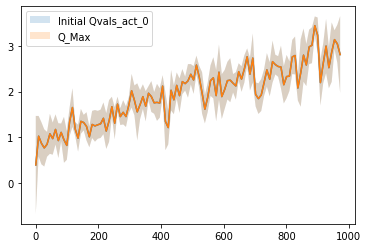

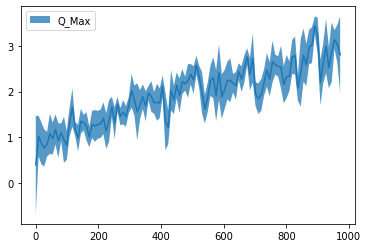

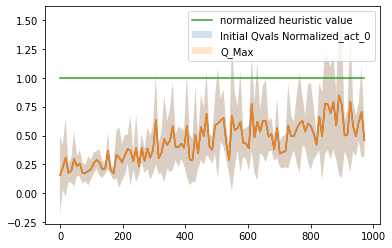

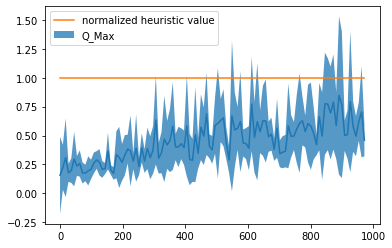

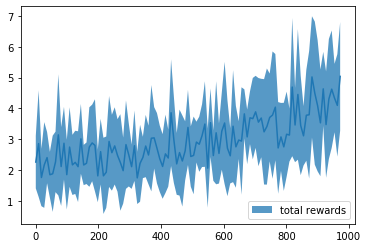

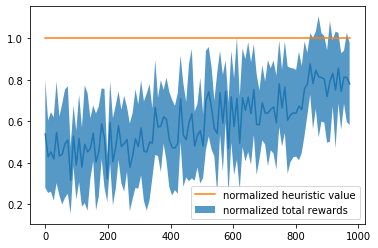

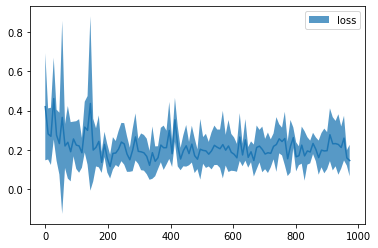

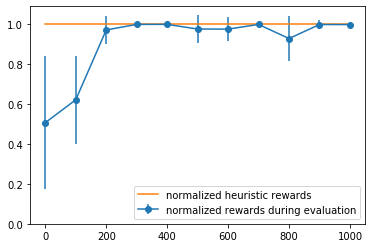

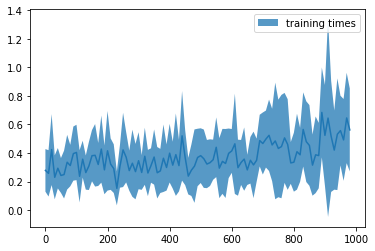

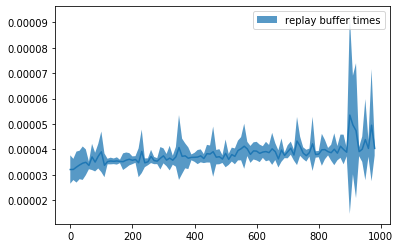

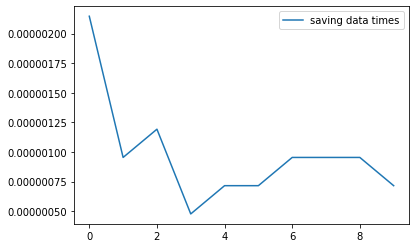

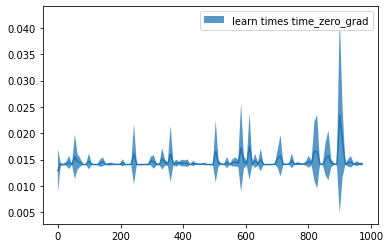

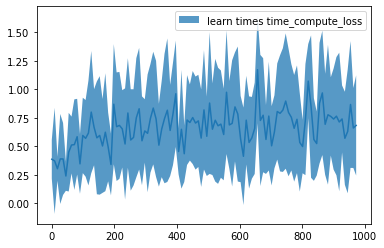

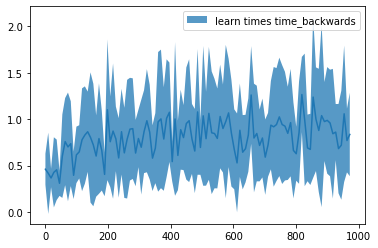

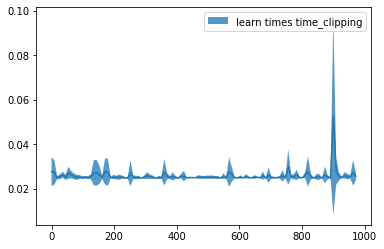

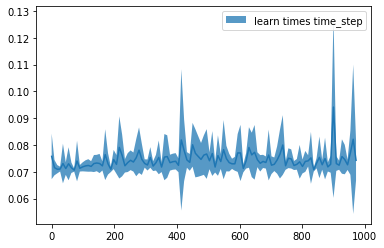

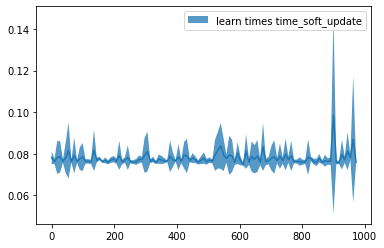

In [13]:
# print
print('printing..')
StuffToBePrinted.Print()
print('.. end printing')

In [14]:
# are you using the net from a previous test?
LoadTest = False
# objects in the middel of training (Aux1 or Aux2) or completely computed (Final)
Path_load = PATH_Final
if LoadTest:
    Runner = LoadDataToEvaluate(Path_load)
mean, std = Evaluate(100, Runner)
print('average normalized return; ', mean)
print('with standard deviation  ; ', std)

the NN was better than (or equal to) the heuristic 83 times out of 100
average normalized return;  0.99736285
with standard deviation  ;  0.03039999


In [15]:
#print(StuffToBePrinted.Initial_Qvals)

TO DO:
- print time for saving
- better heuristic / optimal solutions
- make the second load just load the net and not the replay buffer and shit

WRITING TIPS (https://www.python.org/dev/peps/pep-0008/#documentation-strings):
- comment what the function does

Finally, we load and solve instances from classical benchmark to test how good is our method.
Instances are taken from http://hjemmesider.diku.dk/~pisinger/codes.html 

Our algorithm works with normalized quantities, check for discretization errors

In [16]:
PATH_images_evaluation = PATH + 'images/evaluation/'
# hard
Hard = [
    PATH+"Benchmark_instances/hardinstances_pisinger/",
    ['11','12','13','14','15','16'],
    #['20','50','100','200','500','1000','2000','5000','10000'],
    ['20','50','100'],
    '1000',
    'hardinstances_'
]
# small
Small = [
    PATH+"Benchmark_instances/smallcoeff_pisinger/",
    ['1','2','3','4','5','6','9'],
    #['50','100','200','500','1000','2000','5000','10000'],
    ['50','100'],
    '1000', # there is also a 10000
    'smallcoeff_'
]
# large
Large = [
    PATH+"Benchmark_instances/largecoeff_pisinger/",
    ['1','2','3','4','5','6','9'],
    #['50','100','200','500','1000','2000','5000','10000'],
    ['50','100'],
    '100000', # there is also a 10000
    'largecoeff_'
]

In [17]:
import csv

def Separate_CSV_File(csv_reader, instance):
    
    """ This function takes the reader of a csv file of the benchmark.
        One of this files contain 100 tasks. This function separates
        the rows of the csv file based on the tasks they belong to.
        The output is a array of lists. Each list has the rows belonging 
        to that task (all information needed).
    """
    
    Tasks_Files = []
    Aux = []
    counter = 1
    for row in csv_reader:
        if len(row)>0: # row not empty
            if row[0]==instance.replace('.csv','')+'_'+str(counter):
                if len(Aux)!=0:
                    Tasks_Files.append(Aux)
                    Aux = []
                counter+= 1
            else:
                Aux.append(row)
    Tasks_Files.append(Aux)
    
    return Tasks_Files

def TaskFromCSV(task_file):
    
    """ This function takes a list of rows defining a task
        and create the object task.
    """
    
    Objects = []
    for i in range(len(task_file)):
        if i == 0 or i == len(task_file)-1: # not useful information
            continue
        if i == 1: # capacity
            total_capacity = int(task_file[i][0].replace('c ',''))
        else:
            if i ==2: # opt_solution
                opt_solution = int(task_file[i][0].replace('z ',''))
            else:
                if i == 3: # time
                    time = float(task_file[i][0].replace('time ',''))
                else:
                    prize = int(task_file[i][1])
                    weight = int(task_file[i][2])
                    obj = ObjectCass(prize,weight)
                    Objects.append(obj)
    
    total_capacity = float(total_capacity)
    prize_max = float(max([obj.Prize for obj in Objects]))
    for obj in Objects:
        obj.Weight = torch.tensor(float(obj.Weight)/total_capacity)
        obj.Prize = torch.tensor(float(obj.Prize)/prize_max)
        obj.Ratio = obj.Prize/obj.Weight
    opt_solution = float(opt_solution/prize_max)
    
    task = TaskClass( Objects, torch.tensor(1).float(), opt_solution = opt_solution)

    return task

def LoadTasks(path, instance):
    
    """ This function takes the path of an instance (= collection of 100 tasks).
        and returns a list of lists of rows defining the tasks
    """
    csv_file = open(path+instance)
    csv_reader = csv.reader(csv_file, delimiter=',')
    Tasks_Files = Separate_CSV_File(csv_reader, instance)
    
    return Tasks_Files

def EvaluateFile(path_benchmark, instance, Runner):
    
    heuristic_opt = 0
    RL_opt = 0
    G_tot = []
    heuristic_tot = []
    opt_solution_tot = []
    Tasks_Files = LoadTasks(path_benchmark,instance)
    for task_file in Tasks_Files:
        
        #if task_file == Tasks_Files[4]:
        #    print('remove me')
        #    break
        
        # create task object from file
        task = TaskFromCSV(task_file)
        # perform new task
        G, heuristic = Runner.NewEvaluationTask(task = task)
        G_tot.append(G)
        heuristic_tot.append(heuristic)
        opt_solution_tot.append(task.opt_solution)
        if G >= task.opt_solution:
            RL_opt+=1
        if heuristic >= task.opt_solution:
            heuristic_opt+=1
    # each instance has 100 tasks (due to how the instances were written originally)
    print('RL        reached the optimal solution: '+str(RL_opt)+' times out of '+str(len(Tasks_Files))) 
    print('heuristic reached the optimal solution: '+str(heuristic_opt)+' times out of '+str(len(Tasks_Files))) 
    
    R_norm = [G_tot[i]/opt_solution_tot[i] for i in range(len(G_tot))]
    mean = np.mean(R_norm)
    std = np.std(R_norm)
    H_norm = [heuristic_tot[i]/opt_solution_tot[i] for i in range(len(heuristic_tot))]
    h_mean = np.mean(H_norm)
    h_std = np.std(H_norm)
    
    return mean, std, h_mean, h_std

In [18]:
for group in [Small, Large, Hard]:
    continue
    path_benchmark = group[0]
    Types = group[1]
    Numbers = group[2]
    range_number = group[3]
    name_for_string = group[4]
    for n in Numbers:
        Instances_Names = []
        Results = []
        for t in Types:
            instance_name = 'knapPI_'+t+'_'+n+'_'+range_number+'.csv'
            mean, std, h_mean, h_std = EvaluateFile(path_benchmark, instance_name, Runner)
            Results.append([instance_name, mean, std, h_mean, h_std])
        # print
        print('printing instances with '+n+' objects')
        plt.figure()
        means  = [res[1] for res in Results]
        stds   = [res[2] for res in Results]
        h_means  = [res[3] for res in Results]
        h_stds   = [res[4] for res in Results]
        x_axis = np.arange(len(means))
        Ones = [1 for j in range(len(x_axis))]
        plt.bar(x_axis, Ones, label = 'optimal solution of Pisinger\'s instances', width = 0.25)
        #plt.bar(x_axis, means, yerr=stds,fmt='o-', label = 'Results on Pisinger\'s instances') # 
        plt.bar(x_axis+0.25, means, yerr=stds, label = 'RL', width = 0.25) # 
        plt.bar(x_axis+0.5, h_means, yerr=h_stds, label = 'heuristic', width = 0.25) # 

        plt.ylim(bottom=0)
        plt.legend()
        leg = plt.legend( loc = 'lower left')       
        plt.savefig(PATH_images_evaluation+name_for_string+'_n'+n+'.png', bbox_inches='tight')

Now I try to train on pisinger and test both on pisinger and random

In [19]:
Instances_Names = []
#for group in [Small, Large, Hard]:
for group in [Hard]:
    path_benchmark = group[0]
    Types = group[1]
    Numbers = group[2]
    range_number = group[3]
    name_for_string = group[4]
    for n in Numbers:
        Results = []
        for t in Types:
            Instances_Names.append(['knapPI_'+t+'_'+n+'_'+range_number+'.csv', path_benchmark])

Task_Files = []
for name, path_benchmark in Instances_Names:
    TT = LoadTasks(path_benchmark,name)
    for t in TT:
        Task_Files.append(t)
    
Tasks = [TaskFromCSV(task_file) for task_file in Task_Files]

In [20]:
# seed
random.seed(1234)
# num episode to be generated
num_iterations = int(1e4)
# num replay buffers in repaly buffer
num_replay_buffers = 3 # too much handcrafted/hacky
num_input_features = 5 # prize, weight, ratio, res_capacity, Bool_alreday_chosen
# transformer details
h_model = 512
num_head = 8
num_layers = 6
dim_feedforward = h_model
p_dropout = 0.1
# learning rate
lr = 1e-4
# minimum and maximum epsilon value
epsilon_max = 1
epsilon_min = 0.05
# how many transiction can you store in one buffer
replay_lenght = 1e5
# minibatch dimension
minibatch_size = min(int(num_iterations/100),512)
# how many times do you want to evaluate the algorithm mid-traing?
unit_evaluation = int(num_iterations/10)
# soft update
tau = 0.005
# paths
PATH = ''
PATH_Aux1 = PATH+'Saved_objects_Aux1/'
PATH_Aux2 = PATH+'Saved_objects_Aux2/'
PATH_Final = PATH+'Final_Objects/'
PATH_images_training = PATH + 'images/training/'

# is it a new test?
LoadTest = False
# objects in the middel of training (Aux) or completely computed (Final)
Path_load1 = PATH_Aux1
Path_load2 = PATH_Aux2
if LoadTest:
    try: # if both files are saved withoud problems take the most recent one
        num_iterations_start1, Learner1, Runner1, env1, Model1, ReplayMemory1, StuffToBePrinted1 = LoadDataToTrain(Path_load1)
        num_iterations_start2, Learner2, Runner2, env2, Model2, ReplayMemory2, StuffToBePrinted2 = LoadDataToTrain(Path_load2)        
        if num_iterations_start1>num_iterations_start2:
            num_iterations_start, Learner, Runner, env, Model, ReplayMemory, StuffToBePrinted = LoadDataToTrain(Path_load1)
        else:
            num_iterations_start, Learner, Runner, env, Model, ReplayMemory, StuffToBePrinted = LoadDataToTrain(Path_load2)
    except: # one of the two files is currupted
        try:
            num_iterations_start, Learner, Runner, env, Model, ReplayMemory, StuffToBePrinted = LoadDataToTrain(Path_load1)
        except:
            num_iterations_start, Learner, Runner, env, Model, ReplayMemory, StuffToBePrinted = LoadDataToTrain(Path_load2)
else:
    # environment
    env = EnvironmentClass(num_objs_min, num_objs_max)
    # model
    Net_current = Net_Attention(num_input_features,h_model, num_head ,num_layers, dim_feedforward, p_dropout)
    Net_target  = Net_Attention(num_input_features,h_model, num_head ,num_layers, dim_feedforward, p_dropout)
    Model = ModelClass(Net_current, Net_target, 'eps-greedy', 'greedy', epsilon_max, epsilon_min)
    # Replay Memory
    ReplayMemory = []
    for i in range(num_replay_buffers):
        ReplayMemory.append(ReplayMemoryClass(replay_lenght, minibatch_size))
    # Learner
    optimizer = torch.optim.RMSprop(Net_current.parameters(), lr = lr)
    Learner = LearnerClass(Model, optimizer, tau)
    # Runner
    Runner = RunnerClass(env, Model)
    # print
    StuffToBePrinted = StuffToBePrintedClass(PATH_images_training, [], [], [], [], [])    
    # zero if you start a new test
    num_iterations_start = 0

In [21]:
for iteration_counter in range(num_iterations_start, num_iterations):
    if iteration_counter%100==0:
        time_start = time.time()
        StuffToBePrinted.AddTime(time.time()-time_start,'saving data')
        print('task number: ',(iteration_counter))
        if iteration_counter%200==0:
            SaveData(iteration_counter,Learner,Runner,ReplayMemory,StuffToBePrinted, PATH_Aux1)
        else:
            SaveData(iteration_counter,Learner,Runner,ReplayMemory,StuffToBePrinted, PATH_Aux2)
    # perform new task
    
    time_start = time.time()
    Transitions, target_heuristic, G, initial_Q_vals = Runner.NewTrainingTask(iteration_counter, num_iterations, task = random.choice(Tasks))
    StuffToBePrinted.AddTime(time.time()-time_start,'training')
    if torch.isnan(initial_Q_vals).any():
        print('NaN error!!!')
        stop
    
    # save transition
    time_start = time.time()
    if len(Transitions[0][0].ObjectsFeatures) == 20:
        index_replay_buffer = 0
    if len(Transitions[0][0].ObjectsFeatures) == 50:
        index_replay_buffer = 1
    if len(Transitions[0][0].ObjectsFeatures) == 100:
        index_replay_buffer = 2
    ReplayMemory[index_replay_buffer].Add(Transitions)
    StuffToBePrinted.AddTime(time.time()-time_start,'replay buffer')

    # learn        
    if iteration_counter>= ReplayMemory[0].minibatch_size:
        time_start = time.time()    
        loss, Times_loss = Learner.Learning_step(Minibatch(ReplayMemory))
        StuffToBePrinted.AddElements(Initial_Qvals = [torch.max(initial_Q_vals).detach()], G = G, 
                                     heuristic_target = target_heuristic, loss = loss)
        StuffToBePrinted.AddTime(Times_loss,'learn')
    
    # evaluate mid-training
    if iteration_counter%unit_evaluation == 0:
        mean, std = Evaluate(100, Runner)
        StuffToBePrinted.AddElements(Evaluation = [mean, std, iteration_counter])
        
# evaluate after training
mean, std = Evaluate(100, Runner)
StuffToBePrinted.AddElements(Evaluation = [mean, std, iteration_counter])
# save data
SaveData(num_iterations,Learner,Runner,ReplayMemory,StuffToBePrinted, PATH_Final)

task number:  0
the NN was better than (or equal to) the heuristic 28 times out of 100
task number:  100
the NN was better than (or equal to) the heuristic 1 times out of 100
task number:  200
the NN was better than (or equal to) the heuristic 10 times out of 100
task number:  300
the NN was better than (or equal to) the heuristic 13 times out of 100
task number:  400
the NN was better than (or equal to) the heuristic 14 times out of 100
task number:  500
the NN was better than (or equal to) the heuristic 54 times out of 100
task number:  600
the NN was better than (or equal to) the heuristic 22 times out of 100
task number:  700
the NN was better than (or equal to) the heuristic 78 times out of 100
task number:  800
the NN was better than (or equal to) the heuristic 85 times out of 100
task number:  900
the NN was better than (or equal to) the heuristic 79 times out of 100
the NN was better than (or equal to) the heuristic 57 times out of 100


printing..
.. end printing


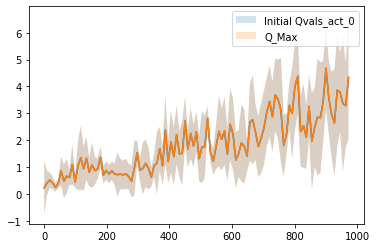

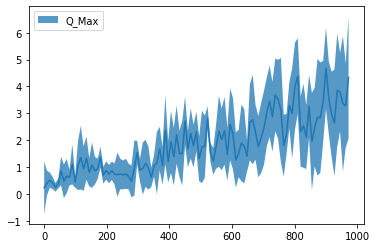

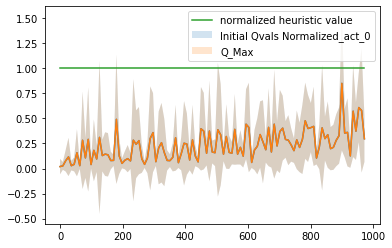

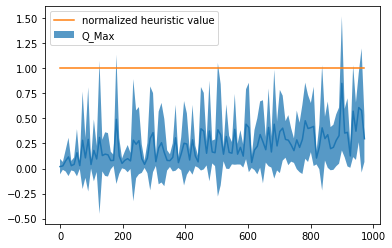

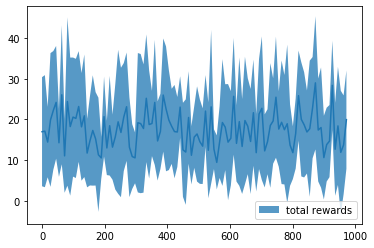

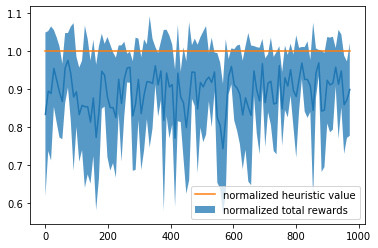

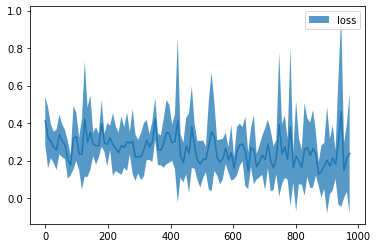

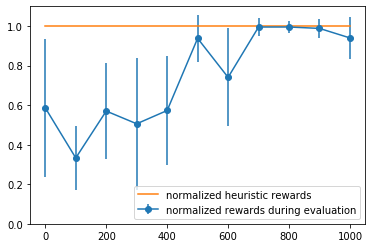

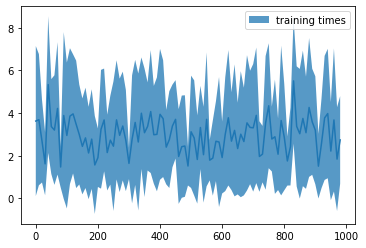

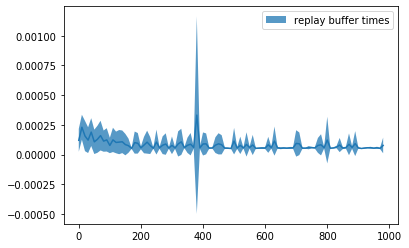

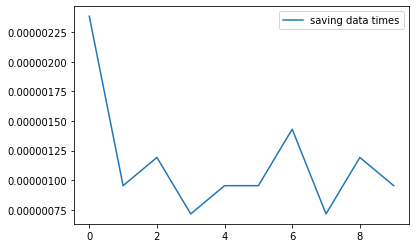

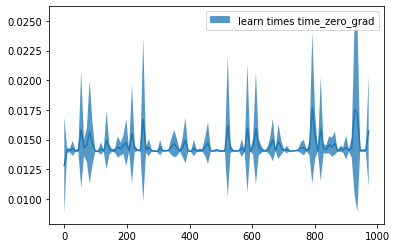

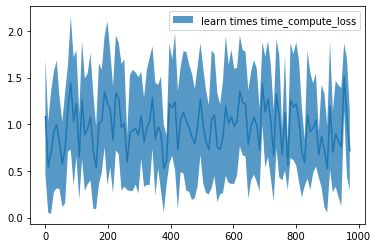

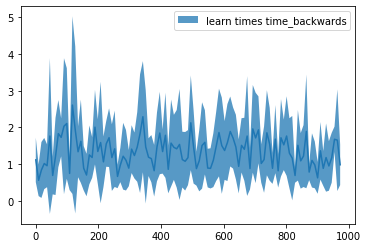

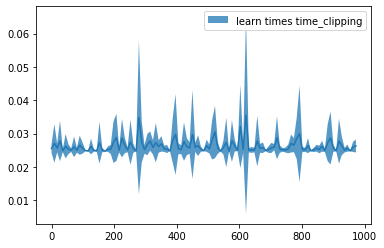

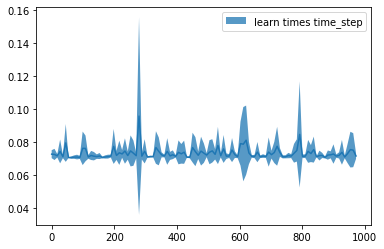

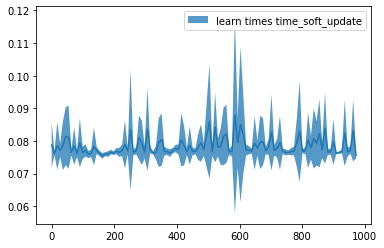

In [22]:
# print
print('printing..')
StuffToBePrinted.Print()
print('.. end printing')

In [23]:
# are you using the net from a previous test?
LoadTest = False
# objects in the middel of training (Aux1 or Aux2) or completely computed (Final)
Path_load = PATH_Final
if LoadTest:
    Runner = LoadDataToEvaluate(Path_load)
mean, std = Evaluate(100, Runner)
print('average normalized return; ', mean)
print('with standard deviation  ; ', std)

the NN was better than (or equal to) the heuristic 62 times out of 100
average normalized return;  0.9691227
with standard deviation  ;  0.07327344


RL        reached the optimal solution: 52 times out of 100
heuristic reached the optimal solution: 33 times out of 100
RL        reached the optimal solution: 41 times out of 100
heuristic reached the optimal solution: 17 times out of 100
RL        reached the optimal solution: 23 times out of 100
heuristic reached the optimal solution: 20 times out of 100
RL        reached the optimal solution: 7 times out of 100
heuristic reached the optimal solution: 12 times out of 100
RL        reached the optimal solution: 4 times out of 100
heuristic reached the optimal solution: 1 times out of 100
RL        reached the optimal solution: 6 times out of 100
heuristic reached the optimal solution: 8 times out of 100
printing instances with 20 objects
RL        reached the optimal solution: 32 times out of 100
heuristic reached the optimal solution: 36 times out of 100
RL        reached the optimal solution: 20 times out of 100
heuristic reached the optimal solution: 29 times out of 100
RL        

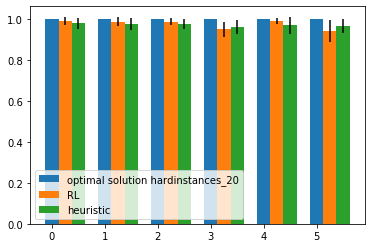

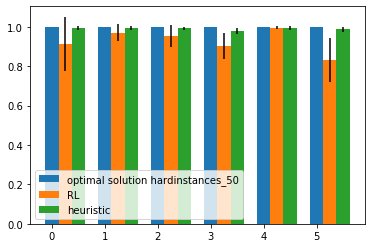

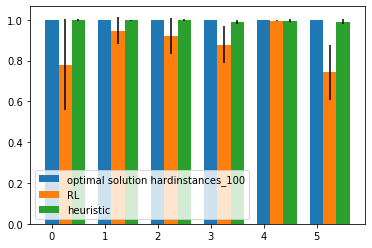

In [24]:
#for group in [Small, Large, Hard]:
for group in [Hard]:
    path_benchmark = group[0]
    Types = group[1]
    Numbers = group[2]
    range_number = group[3]
    name_for_string = group[4]
    for n in Numbers:
        Instances_Names = []
        Results = []
        for t in Types:
            instance_name = 'knapPI_'+t+'_'+n+'_'+range_number+'.csv'
            mean, std, h_mean, h_std = EvaluateFile(path_benchmark, instance_name, Runner)
            Results.append([instance_name, mean, std, h_mean, h_std])
        # print
        print('printing instances with '+n+' objects')
        plt.figure()
        means  = [res[1] for res in Results]
        stds   = [res[2] for res in Results]
        h_means  = [res[3] for res in Results]
        h_stds   = [res[4] for res in Results]
        x_axis = np.arange(len(means))
        Ones = [1 for j in range(len(x_axis))]
        plt.bar(x_axis, Ones, label = 'optimal solution ' + name_for_string + str(n), width = 0.25)
        #plt.bar(x_axis, means, yerr=stds,fmt='o-', label = 'Results on Pisinger\'s instances') # 
        plt.bar(x_axis+0.25, means, yerr=stds, label = 'RL', width = 0.25) # 
        plt.bar(x_axis+0.5, h_means, yerr=h_stds, label = 'heuristic', width = 0.25) # 

        plt.ylim(bottom=0)
        plt.legend()
        leg = plt.legend( loc = 'lower left')       
        plt.savefig(PATH_images_evaluation+name_for_string+'_n'+n+'.png', bbox_inches='tight')

In [25]:
from datetime import datetime

Input = open('Last_run_date.txt','w')
Input.write("Today's date: "+ datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
Input.close()